## Installments

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
save_files = True

In [3]:
# load installments file
df_inst = pd.read_csv('input/installments_payments.csv')
df_inst.info()
display(df_inst.head())
display(df_inst.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [4]:
df_inst['DAY_DIFF'] = df_inst['DAYS_INSTALMENT']-df_inst['DAYS_ENTRY_PAYMENT']
df_inst['PAY_DIFF'] = df_inst['AMT_INSTALMENT']-df_inst['AMT_PAYMENT']

df_inst.rename(columns={'NUM_INSTALMENT_VERSION':'VERSION',
                        'NUM_INSTALMENT_NUMBER':'NUM',
                        'DAYS_INSTALMENT':'DAY_DUE',
                        'DAYS_ENTRY_PAYMENT':'DAY_PAY',
                        'AMT_INSTALMENT':'AMT',
                        'AMT_PAYMENT':'PAID'},
               inplace=True)

In [5]:
id_prev_to_curr = df_inst.groupby('SK_ID_PREV').SK_ID_CURR.first()

df_inst.drop('SK_ID_CURR',axis=1,inplace=True)

In [6]:
df_inst.sort_values(by=['SK_ID_PREV','DAY_DUE'],inplace=True)
df_inst.reset_index(inplace=True,drop=True)

df_inst.head()

,SK_ID_PREV,VERSION,NUM,DAY_DUE,DAY_PAY,AMT,PAID,DAY_DIFF,PAY_DIFF
0,1000001,1.0,1,-268.0,-294.0,6404.310,6404.310,26.0,0.0
1,1000001,2.0,2,-238.0,-244.0,62039.115,62039.115,6.0,0.0
2,1000002,1.0,1,-1600.0,-1611.0,6264.000,6264.000,11.0,0.0
3,1000002,1.0,2,-1570.0,-1575.0,6264.000,6264.000,5.0,0.0
4,1000002,1.0,3,-1540.0,-1559.0,6264.000,6264.000,19.0,0.0


In [7]:
agg_funcs = {
    'VERSION':['nunique'],
    'NUM':['first','last'],
    'DAY_DUE':['min','max','first','last'],
    'DAY_PAY':['min','max','first','last'],
    'AMT':['min','max','first','last','mean'],
    'PAID':['min','max','first','last','mean'],
    'DAY_DIFF':['min','max','first','last','mean'],
    'PAY_DIFF':['min','max','first','last','mean']
}

inst_grouped = df_inst.groupby('SK_ID_PREV').agg(agg_funcs)

inst_grouped.columns = ['INST_'+'_'.join(x) for x in inst_grouped.columns.values]

del df_inst

inst_grouped.head()

,INST_VERSION_nunique,INST_NUM_first,INST_NUM_last,INST_DAY_DUE_min,INST_DAY_DUE_max,INST_DAY_DUE_first,INST_DAY_DUE_last,INST_DAY_PAY_min,INST_DAY_PAY_max,INST_DAY_PAY_first,...,INST_DAY_DIFF_min,INST_DAY_DIFF_max,INST_DAY_DIFF_first,INST_DAY_DIFF_last,INST_DAY_DIFF_mean,INST_PAY_DIFF_min,INST_PAY_DIFF_max,INST_PAY_DIFF_first,INST_PAY_DIFF_last,INST_PAY_DIFF_mean
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1000001,2,1,2,-268.0,-238.0,-268.0,-238.0,-294.0,-244.0,-294.0,...,6.0,26.0,26.0,6.0,16.000000,0.0,0.000,0.0,0.0,0.000000
1000002,2,1,4,-1600.0,-1510.0,-1600.0,-1510.0,-1611.0,-1554.0,-1611.0,...,5.0,44.0,11.0,44.0,19.750000,0.0,0.000,0.0,0.0,0.000000
1000003,1,1,3,-94.0,-34.0,-94.0,-34.0,-108.0,-49.0,-108.0,...,14.0,17.0,14.0,15.0,15.333333,0.0,0.000,0.0,0.0,0.000000
1000004,2,1,7,-862.0,-682.0,-862.0,-682.0,-881.0,-695.0,-881.0,...,10.0,58.0,19.0,13.0,26.714286,0.0,0.000,0.0,0.0,0.000000
1000005,1,1,10,-1688.0,-1418.0,-1688.0,-1418.0,-1687.0,-1433.0,-1687.0,...,-3.0,36.0,-1.0,15.0,8.454545,0.0,14710.815,0.0,0.0,1337.600455


In [8]:
inst_grouped['SK_ID_CURR'] = id_prev_to_curr

inst_idcurr = inst_grouped.groupby('SK_ID_CURR').agg(['min','max','sum','mean'])
inst_idcurr['INST_CNT'] = id_prev_to_curr.value_counts()

inst_idcurr.columns = ['_'.join(x) for x in inst_idcurr.columns.values]
inst_cols = inst_idcurr.columns

del inst_grouped

inst_idcurr.head()

,INST_VERSION_nunique_min,INST_VERSION_nunique_max,INST_VERSION_nunique_sum,INST_VERSION_nunique_mean,INST_NUM_first_min,INST_NUM_first_max,INST_NUM_first_sum,INST_NUM_first_mean,INST_NUM_last_min,INST_NUM_last_max,...,INST_PAY_DIFF_first_mean,INST_PAY_DIFF_last_min,INST_PAY_DIFF_last_max,INST_PAY_DIFF_last_sum,INST_PAY_DIFF_last_mean,INST_PAY_DIFF_mean_min,INST_PAY_DIFF_mean_max,INST_PAY_DIFF_mean_sum,INST_PAY_DIFF_mean_mean,INST_CNT_
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,2,3,1.500000,1,2,3,1.5,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
100002,2,2,2,2.000000,1,1,1,1.0,19,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
100003,1,2,4,1.333333,1,1,3,1.0,6,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
100004,2,2,2,2.000000,1,1,1,1.0,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
100005,2,2,2,2.000000,1,1,1,1.0,9,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [9]:
print('loading train...')
df_train = pd.read_csv('input/application_train.csv',index_col='SK_ID_CURR')

print('merging train...')
df_train = df_train.merge(inst_idcurr,how='left',left_index=True,right_index=True)

if save_files:
    print('saving train...')
    df_train[inst_cols].to_csv('input/app_train_ALL_inst.csv')
    
    print('loading test...')
    df_test = pd.read_csv('input/application_test.csv',index_col='SK_ID_CURR')

    print('merging test...')
    df_test = df_test.merge(inst_idcurr,how='left',left_index=True,right_index=True)
   
    print('saving test...')
    df_test[inst_cols].to_csv('input/app_test_ALL_inst.csv')
    
del inst_idcurr

display(df_train.head())

print('Done!')

loading train...
merging train...
saving train...
loading test...
merging test...
saving test...


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INST_PAY_DIFF_first_mean,INST_PAY_DIFF_last_min,INST_PAY_DIFF_last_max,INST_PAY_DIFF_last_sum,INST_PAY_DIFF_last_mean,INST_PAY_DIFF_mean_min,INST_PAY_DIFF_mean_max,INST_PAY_DIFF_mean_sum,INST_PAY_DIFF_mean_mean,INST_CNT_
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.000,0.0,0.00,0.00,0.000,0.0,0.000000,0.000000,0.000000,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.000,0.0,0.00,0.00,0.000,0.0,0.000000,0.000000,0.000000,3.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.000,0.0,0.00,0.00,0.000,0.0,0.000000,0.000000,0.000000,1.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.000,0.0,0.00,0.00,0.000,0.0,0.000000,0.000000,0.000000,3.0
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,4.626,0.0,0.18,0.18,0.036,0.0,1744.521923,2257.277637,451.455527,5.0


Done!


## model

In [10]:
def plot_roc_curve(y_true, y_pred, color='darkorange',plot_random=True,label='ROC curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    score = roc_auc_score(y_true, y_pred)
    
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=label+' (area = %0.2f)' % score)
    
    if plot_random:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

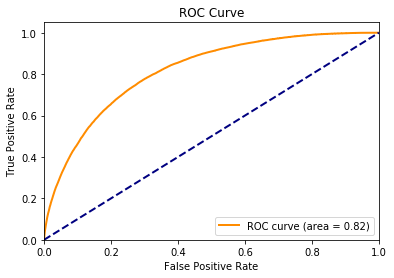

In [11]:
target_counts = df_train.TARGET.value_counts()
targ1_weight = target_counts[0]/target_counts[1]
weights = df_train.TARGET.replace({0:1, 1:targ1_weight}).values

dtypes = df_train.dtypes
cols_categ = dtypes[dtypes=='object'].index.tolist()
for col in cols_categ:
    df_train[col] = df_train[col].astype('category')
    
y_true = df_train.TARGET
X = df_train.drop('TARGET',axis=1)
train_data = lgb.Dataset(X, label=y_true, weight=weights)

    
# train
param = {'objective':'binary', 'metric':'auc'}
bst = lgb.train(param, train_data)

#plot roc curve
plt.figure()
plot_roc_curve(y_true, bst.predict(X))

EXT_SOURCE_3                   0.244010
EXT_SOURCE_2                   0.191902
ORGANIZATION_TYPE              0.094836
EXT_SOURCE_1                   0.063930
AMT_CREDIT                     0.021136
OCCUPATION_TYPE                0.021117
INST_PAID_min_mean             0.017976
DAYS_BIRTH                     0.017797
AMT_GOODS_PRICE                0.016646
INST_PAID_min_sum              0.016181
NAME_EDUCATION_TYPE            0.016078
AMT_ANNUITY                    0.015783
CODE_GENDER                    0.014253
DAYS_EMPLOYED                  0.014223
OWN_CAR_AGE                    0.012208
INST_DAY_DIFF_min_mean         0.010212
INST_AMT_min_min               0.009594
DAYS_ID_PUBLISH                0.007397
INST_DAY_DIFF_min_max          0.006816
INST_DAY_DIFF_min_sum          0.005524
INST_AMT_last_max              0.005317
INST_DAY_DUE_min_min           0.005173
FLAG_DOCUMENT_3                0.004648
NAME_FAMILY_STATUS             0.004600
DAYS_LAST_PHONE_CHANGE         0.004407


Text(0,0.5,'cumulative frac gain')

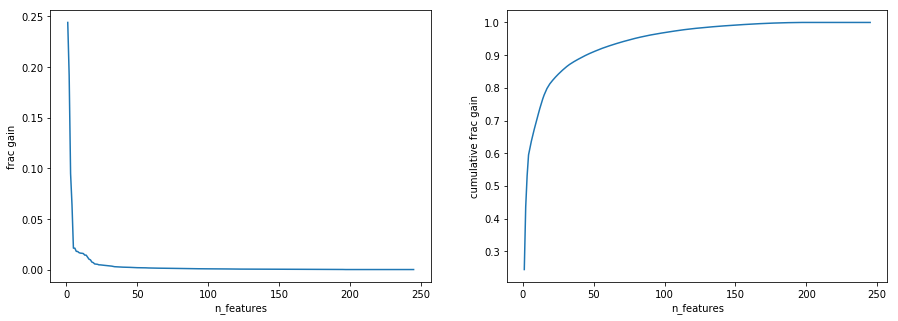

In [12]:
plt.figure(figsize=(10,30))

feat_imp = pd.DataFrame({'split':bst.feature_importance(importance_type='split'),
                         'gain':bst.feature_importance(importance_type='gain')},
                        index=bst.feature_name())

total_gain = feat_imp['gain'].sum()
frac_gain = feat_imp['gain']/total_gain
frac_gain = frac_gain.sort_values(ascending=False)

display(frac_gain.head(30))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(frac_gain))+1, frac_gain)
plt.xlabel('n_features')
plt.ylabel('frac gain')

plt.subplot(1,2,2)
plt.plot(np.arange(len(frac_gain))+1,frac_gain.cumsum())
plt.xlabel('n_features')
plt.ylabel('cumulative frac gain')

In [13]:
# select top n columns from cc by importance
n_cols = 60
select_cols = frac_gain[frac_gain.index.str.contains('INST_')].index[:n_cols]

if save_files:
    df_train[select_cols].to_csv('input/app_train_SELECT_inst.csv')
    df_test[select_cols].to_csv('input/app_test_SELECT_inst.csv')
    
frac_gain[select_cols]

INST_PAID_min_mean           0.017976
INST_PAID_min_sum            0.016181
INST_DAY_DIFF_min_mean       0.010212
INST_AMT_min_min             0.009594
INST_DAY_DIFF_min_max        0.006816
INST_DAY_DIFF_min_sum        0.005524
INST_AMT_last_max            0.005317
INST_DAY_DUE_min_min         0.005173
INST_AMT_first_min           0.003977
INST_PAY_DIFF_mean_mean      0.003819
INST_DAY_PAY_max_max         0.003767
INST_DAY_DIFF_min_min        0.003536
INST_PAY_DIFF_max_mean       0.003375
INST_NUM_last_sum            0.003099
INST_DAY_DUE_min_mean        0.002812
INST_PAID_min_min            0.002657
INST_NUM_last_mean           0.002561
INST_DAY_DUE_max_max         0.002363
INST_AMT_max_mean            0.002348
INST_AMT_last_mean           0.002328
INST_DAY_PAY_min_sum         0.002222
INST_DAY_PAY_min_min         0.002162
INST_AMT_min_mean            0.002143
INST_DAY_DIFF_mean_min       0.001952
INST_PAY_DIFF_mean_sum       0.001829
INST_DAY_PAY_last_max        0.001827
INST_PAID_la